# Zeeguu API Architecture Reconstruction - Basic Radon Analysis

This notebook provides a comprehensive analysis of the Zeeguu API (backend) code using Radon – a Python tool for computing various code metrics. We will extract architectural insights using metrics such as:

1. **Cyclomatic Complexity (CC):** Identifies overly complex functions.
2. **Maintainability Index (MI):** Evaluates overall maintainability of modules.
3. **Raw Metrics:** Counts lines of code (LOC, LLOC, SLOC) and comment ratios.

These metrics will help us construct various architectural viewpoints.

In [1]:
import os
import sys
import subprocess

def install_package(package):
    try:
        __import__(package.replace('-', '_'))
        print(f"{package} is already installed.")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install radon and additional packages for visualization
install_package('radon')
install_package('matplotlib')
install_package('pandas')
install_package('networkx')
install_package('pydot')
install_package('squarify')

# Verify Radon installation by printing its version
try:
    subprocess.check_call([sys.executable, "-m", "radon", "--version"])
except Exception as e:
    print("Error calling radon. Please ensure it is installed properly.")

radon is already installed.
matplotlib is already installed.
pandas is already installed.
networkx is already installed.
pydot is already installed.
squarify is already installed.


In [2]:
# ---- Path Configuration ----
import os

TOOLS_DIR = os.getcwd()  # Expected: ...\Tools
BASE_DIR = os.path.abspath(os.path.join(TOOLS_DIR, '..'))
DATA_DIR = os.path.join(BASE_DIR, 'Data')
API_DIR = os.path.join(DATA_DIR, 'api')

# New variable for radon outputs
RADON_OUTPUT_DIR = os.path.join(BASE_DIR, 'output', 'radon')
os.makedirs(RADON_OUTPUT_DIR, exist_ok=True)

print("TOOLS_DIR:", TOOLS_DIR)
print("BASE_DIR:", BASE_DIR)
print("DATA_DIR:", DATA_DIR)
print("API_DIR:", API_DIR)
print("RADON_OUTPUT_DIR:", RADON_OUTPUT_DIR)

TOOLS_DIR: c:\Programming\Architecture\ArchitecturalRecovery\Tools
BASE_DIR: c:\Programming\Architecture\ArchitecturalRecovery
DATA_DIR: c:\Programming\Architecture\ArchitecturalRecovery\Data
API_DIR: c:\Programming\Architecture\ArchitecturalRecovery\Data\api
RADON_OUTPUT_DIR: c:\Programming\Architecture\ArchitecturalRecovery\output\radon


## 1. Basic Project Structure Analysis

We'll begin by listing the directory structure for the API. On Windows, we replace the Unix shell commands with Python functions.

In [3]:
def list_directories(root_dir):
    dirs = []
    for dirpath, dirnames, _ in os.walk(root_dir):
        # Exclude hidden directories
        dirnames[:] = [d for d in dirnames if not d.startswith('.')]
        dirs.append(os.path.relpath(dirpath, root_dir))
    return sorted(dirs)

print("API (Backend) Structure:")
for d in list_directories(API_DIR):
    print(d)

API (Backend) Structure:
.
__pycache__
tools
tools\__pycache__
tools\crawl_summary
tools\migrations
tools\old
tools\old\__pycache__
tools\old\es_v8_migration
tools\old\es_v8_migration\__pycache__
tools\report_generator
tools\sh
tools\sql
zeeguu
zeeguu\__pycache__
zeeguu\api
zeeguu\api\__pycache__
zeeguu\api\endpoints
zeeguu\api\endpoints\__pycache__
zeeguu\api\endpoints\helpers
zeeguu\api\endpoints\teacher_dashboard
zeeguu\api\test
zeeguu\api\test\__pycache__
zeeguu\api\utils
zeeguu\cl
zeeguu\config
zeeguu\config\__pycache__
zeeguu\core
zeeguu\core\__pycache__
zeeguu\core\account_management
zeeguu\core\behavioral_modeling
zeeguu\core\bookmark_quality
zeeguu\core\content_cleaning
zeeguu\core\content_cleaning\__pycache__
zeeguu\core\content_cleaning\data
zeeguu\core\content_quality
zeeguu\core\content_recommender
zeeguu\core\content_retriever
zeeguu\core\content_retriever\__pycache__
zeeguu\core\crowd_translations
zeeguu\core\definition_of_learned
zeeguu\core\diagrams
zeeguu\core\elastic

In [4]:
def count_python_files(root_dir):
    count = 0
    for dirpath, _, files in os.walk(root_dir):
        for f in files:
            if f.endswith('.py'):
                count += 1
    return count

api_count = count_python_files(API_DIR)

print("Number of Python files in API (Backend): ", api_count)

Number of Python files in API (Backend):  357


## 2-5 API Files Analysis

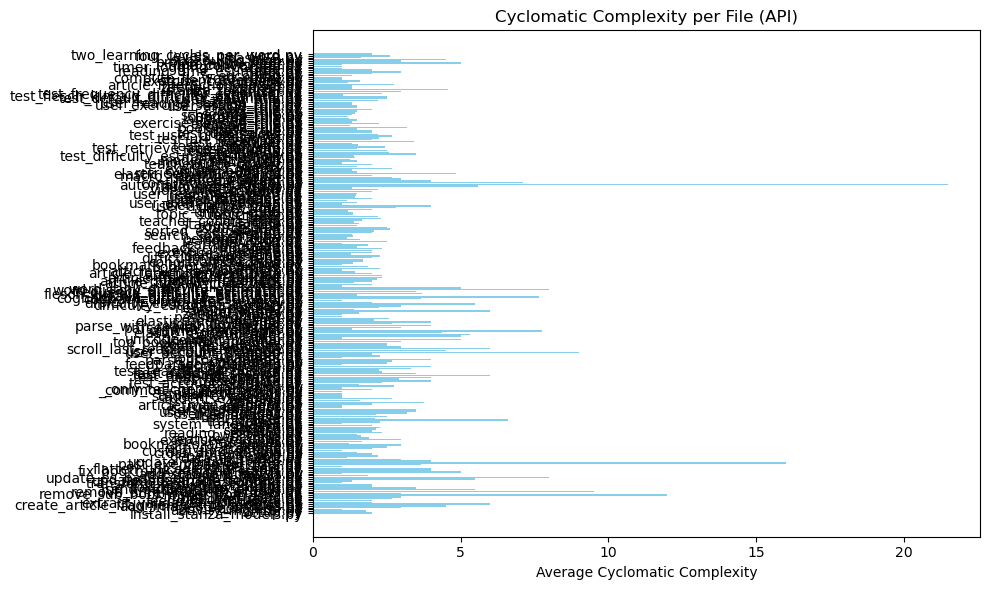

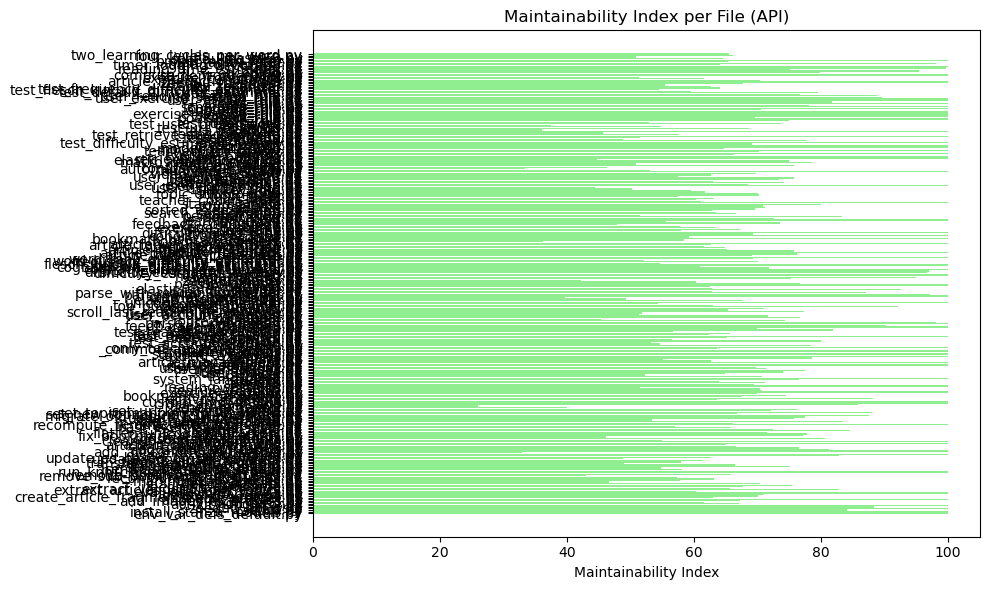

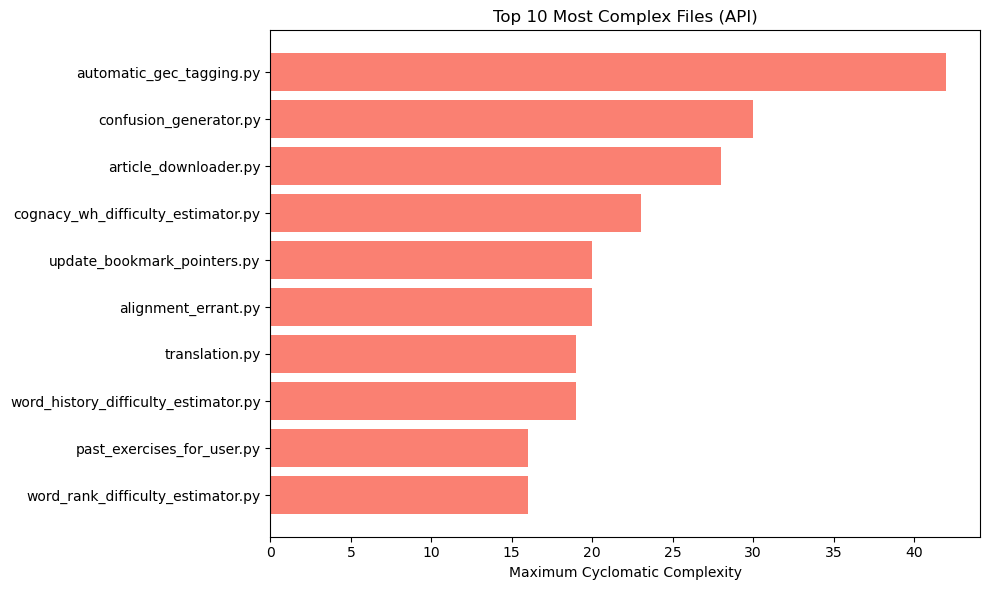

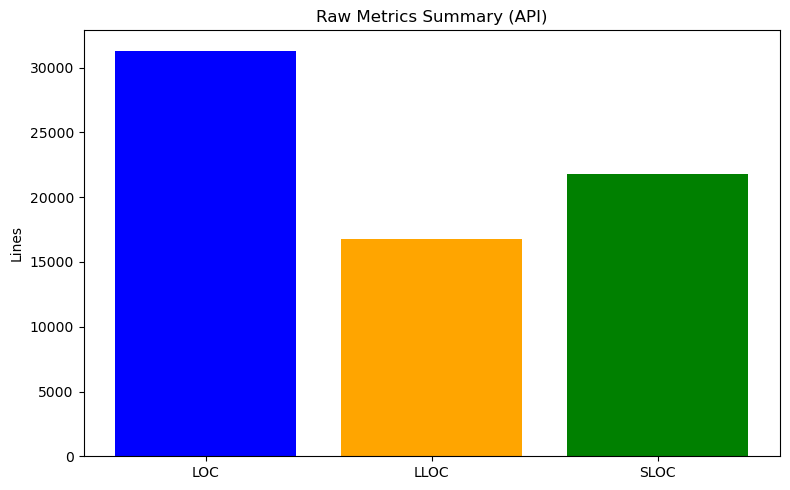

In [5]:
# Visualization

import os
import sys
import subprocess
import json
import matplotlib.pyplot as plt
from pathlib import Path

# Use the API_DIR from the path configuration cell

def get_json_output(command):
    result = subprocess.run(command, capture_output=True, text=True)
    return json.loads(result.stdout)

# --- Cyclomatic Complexity Analysis ---
cc_command = [sys.executable, "-m", "radon", "cc", API_DIR, "-j", "-s", "-a"]
cc_data = get_json_output(cc_command)

# Compute average CC per file.
files = []
avg_complexities = []
for filepath, funcs in cc_data.items():
    complexities = [func["complexity"] for func in funcs]
    avg_cc = sum(complexities) / len(complexities) if complexities else 0
    files.append(Path(filepath).name)
    avg_complexities.append(avg_cc)

plt.figure(figsize=(10, 6))
plt.barh(files, avg_complexities, color='skyblue')
plt.xlabel("Average Cyclomatic Complexity")
plt.title("Cyclomatic Complexity per File (API)")
plt.tight_layout()
plt.show()

# --- Maintainability Index Analysis ---
mi_command = [sys.executable, "-m", "radon", "mi", API_DIR, "-j"]
mi_data = get_json_output(mi_command)

files_mi = []
mi_values = []
for filepath, value in mi_data.items():
    mi = value.get("mi", 0) if isinstance(value, dict) else value
    files_mi.append(Path(filepath).name)
    mi_values.append(mi)

plt.figure(figsize=(10, 6))
plt.barh(files_mi, mi_values, color='lightgreen')
plt.xlabel("Maintainability Index")
plt.title("Maintainability Index per File (API)")
plt.tight_layout()
plt.show()

# --- Top 10 Most Complex Files ---
file_max_cc = []
max_cc = []
for filepath, funcs in cc_data.items():
    if funcs:
        file_complexity = max(func["complexity"] for func in funcs)
        file_max_cc.append(Path(filepath).name)
        max_cc.append(file_complexity)

# Select top 10 files.
top_files = sorted(zip(file_max_cc, max_cc), key=lambda x: x[1], reverse=True)[:10]
top_names, top_values = zip(*top_files)

plt.figure(figsize=(10, 6))
plt.barh(top_names, top_values, color='salmon')
plt.xlabel("Maximum Cyclomatic Complexity")
plt.title("Top 10 Most Complex Files (API)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- Raw Metrics Analysis ---
raw_command = [sys.executable, "-m", "radon", "raw", API_DIR, "-j", "-s"]
raw_data = get_json_output(raw_command)

# Sum LOC, LLOC, and SLOC across all files.
total_loc = sum(stats.get("loc", 0) for stats in raw_data.values())
total_lloc = sum(stats.get("lloc", 0) for stats in raw_data.values())
total_sloc = sum(stats.get("sloc", 0) for stats in raw_data.values())

labels = ['LOC', 'LLOC', 'SLOC']
values = [total_loc, total_lloc, total_sloc]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'orange', 'green'])
plt.ylabel("Lines")
plt.title("Raw Metrics Summary (API)")
plt.tight_layout()
plt.show()

## 2-5 Grouped by Main Package (API Only)

In [6]:
import os
import sys
import json
import subprocess
from collections import defaultdict

def aggregate_cc_by_package(base_dir):
    """Aggregate Cyclomatic Complexity (CC) per package."""
    cmd = [sys.executable, "-m", "radon", "cc", base_dir, "-j", "-s", "-a"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    
    pkg_data = defaultdict(list)
    for filepath, funcs in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        # Use the first folder as the package; if not, label as 'root'
        pkg = relpath.split(os.sep)[0] if os.sep in relpath else "root"
        for func in funcs:
            pkg_data[pkg].append(func["complexity"])
    
    print("Cyclomatic Complexity (CC) by package:")
    for pkg, complexities in pkg_data.items():
        count = len(complexities)
        avg_complexity = sum(complexities) / count if count else 0
        print(f"  {pkg}: {count} functions, avg CC: {avg_complexity:.2f}")

def aggregate_mi_by_package(base_dir):
    """Aggregate Maintainability Index (MI) per package."""
    cmd = [sys.executable, "-m", "radon", "mi", base_dir, "-j"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    
    pkg_data = defaultdict(list)
    for filepath, mi_value in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = relpath.split(os.sep)[0] if os.sep in relpath else "root"
        if isinstance(mi_value, dict):
            pkg_data[pkg].append(mi_value.get("mi", 0))
        else:
            pkg_data[pkg].append(mi_value)
    
    print("Maintainability Index (MI) by package:")
    for pkg, mis in pkg_data.items():
        count = len(mis)
        avg_mi = sum(mis) / count if count else 0
        print(f"  {pkg}: {count} files, avg MI: {avg_mi:.2f}")

def aggregate_raw_by_package(base_dir):
    """Aggregate Raw Metrics (LOC, LLOC, SLOC, comments, etc.) per package."""
    cmd = [sys.executable, "-m", "radon", "raw", base_dir, "-j", "-s"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    
    metrics = ["loc", "lloc", "sloc", "comments", "single_comments", "multi", "blank"]
    pkg_totals = defaultdict(lambda: {metric: 0 for metric in metrics})
    pkg_file_count = defaultdict(int)
    
    for filepath, stats in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = relpath.split(os.sep)[0] if os.sep in relpath else "root"
        pkg_file_count[pkg] += 1
        for metric in metrics:
            pkg_totals[pkg][metric] += stats.get(metric, 0)
    
    print("Raw Metrics by package (averages per file):")
    for pkg in pkg_totals:
        count = pkg_file_count[pkg]
        averages = {metric: pkg_totals[pkg][metric] / count for metric in metrics}
        print(f"  {pkg}: {count} files, averages: {averages}")

if __name__ == "__main__":
    # Use API_DIR instead of a hard-coded path
    print("===== Aggregated Metrics for API =====")
    aggregate_cc_by_package(API_DIR)
    print()
    aggregate_mi_by_package(API_DIR)
    print()
    aggregate_raw_by_package(API_DIR)
    print()


===== Aggregated Metrics for API =====
Cyclomatic Complexity (CC) by package:
  root: 6 functions, avg CC: 1.83
  tools: 137 functions, avg CC: 2.80
  zeeguu: 1511 functions, avg CC: 2.37

Maintainability Index (MI) by package:
  root: 6 files, avg MI: 95.40
  tools: 70 files, avg MI: 71.73
  zeeguu: 282 files, avg MI: 78.20

Raw Metrics by package (averages per file):
  root: 6 files, averages: {'loc': 31.166666666666668, 'lloc': 12.666666666666666, 'sloc': 17.833333333333332, 'comments': 5.666666666666667, 'single_comments': 5.666666666666667, 'multi': 0.0, 'blank': 7.666666666666667}
  tools: 70 files, averages: {'loc': 79.92857142857143, 'lloc': 43.31428571428572, 'sloc': 61.42857142857143, 'comments': 3.1714285714285713, 'single_comments': 2.8, 'multi': 2.2142857142857144, 'blank': 13.485714285714286}
  zeeguu: 282 files, averages: {'loc': 90.54964539007092, 'lloc': 48.351063829787236, 'sloc': 61.698581560283685, 'comments': 4.1879432624113475, 'single_comments': 3.836879432624113

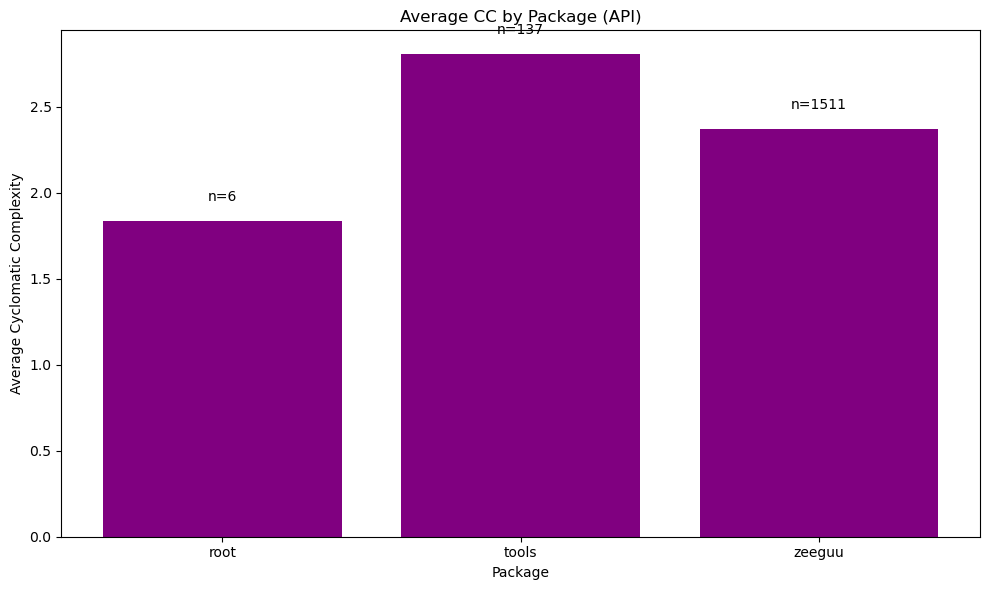

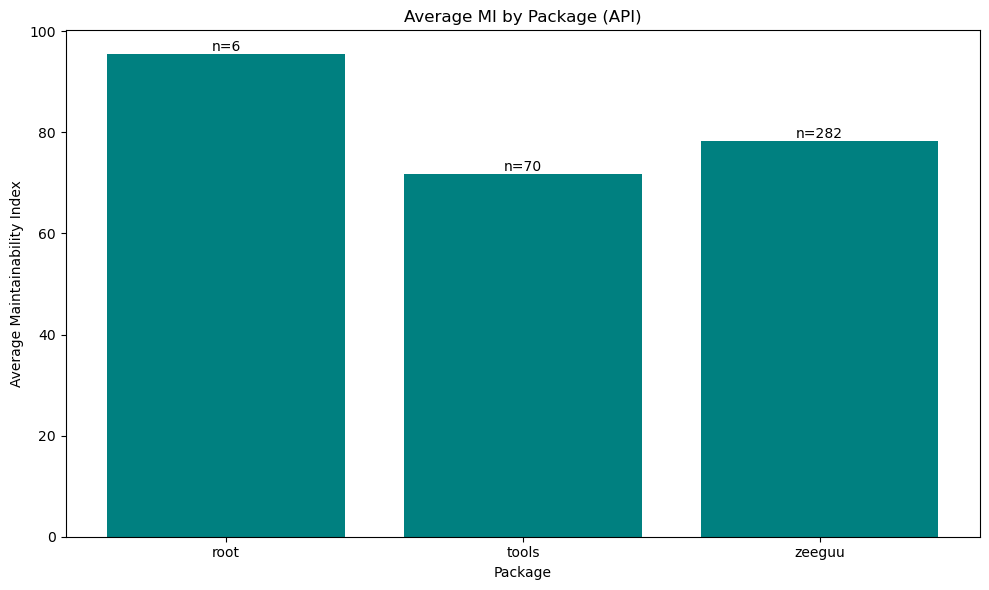

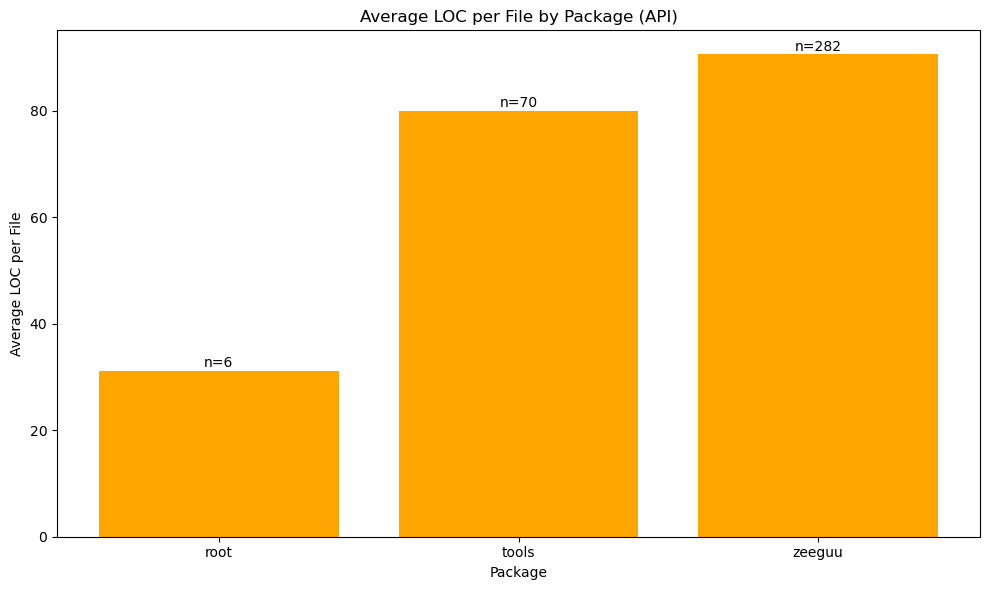

In [7]:
# Visualization of aggregated metrics by package with annotations

import os
import sys
import json
import subprocess
from collections import defaultdict
import matplotlib.pyplot as plt

def aggregate_cc_by_package(base_dir):
    cmd = [sys.executable, "-m", "radon", "cc", base_dir, "-j", "-s", "-a"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    pkg_data = defaultdict(list)
    for filepath, funcs in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = relpath.split(os.sep)[0] if os.sep in relpath else "root"
        for func in funcs:
            pkg_data[pkg].append(func["complexity"])
    return pkg_data

def aggregate_mi_by_package(base_dir):
    cmd = [sys.executable, "-m", "radon", "mi", base_dir, "-j"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    pkg_data = defaultdict(list)
    for filepath, mi_value in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = relpath.split(os.sep)[0] if os.sep in relpath else "root"
        if isinstance(mi_value, dict):
            pkg_data[pkg].append(mi_value.get("mi", 0))
        else:
            pkg_data[pkg].append(mi_value)
    return pkg_data

def aggregate_raw_by_package(base_dir):
    cmd = [sys.executable, "-m", "radon", "raw", base_dir, "-j", "-s"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    metrics = ["loc", "lloc", "sloc", "comments", "single_comments", "multi", "blank"]
    pkg_totals = defaultdict(lambda: {metric: 0 for metric in metrics})
    pkg_file_count = defaultdict(int)
    for filepath, stats in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = relpath.split(os.sep)[0] if os.sep in relpath else "root"
        pkg_file_count[pkg] += 1
        for metric in metrics:
            pkg_totals[pkg][metric] += stats.get(metric, 0)
    return pkg_totals, pkg_file_count

# --- Plot Average Cyclomatic Complexity by Package with annotations ---
if __name__ == "__main__":
    # Aggregate cyclomatic complexity data
    cc_pkg = aggregate_cc_by_package(API_DIR)
    pkg_names = list(cc_pkg.keys())
    avg_cc = [sum(cc_pkg[p]) / len(cc_pkg[p]) if cc_pkg[p] else 0 for p in pkg_names]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pkg_names, avg_cc, color='purple')
    plt.xlabel("Package")
    plt.ylabel("Average Cyclomatic Complexity")
    plt.title("Average CC by Package (API)")
    for bar, pkg in zip(bars, pkg_names):
        count = len(cc_pkg[pkg])
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f"n={count}", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(RADON_OUTPUT_DIR, 'average_cc_by_package.png'))
    plt.show()

    # --- Plot Average Maintainability Index by Package with annotations ---
    mi_pkg = aggregate_mi_by_package(API_DIR)
    pkg_names_mi = list(mi_pkg.keys())
    avg_mi = [sum(mi_pkg[p]) / len(mi_pkg[p]) if mi_pkg[p] else 0 for p in pkg_names_mi]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pkg_names_mi, avg_mi, color='teal')
    plt.xlabel("Package")
    plt.ylabel("Average Maintainability Index")
    plt.title("Average MI by Package (API)")
    for bar, pkg in zip(bars, pkg_names_mi):
        count = len(mi_pkg[pkg])
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f"n={count}", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(RADON_OUTPUT_DIR, 'average_mi_by_package.png'))
    plt.show()

    # --- Plot Average LOC per File by Package with annotations ---
    raw_pkg, pkg_file_count = aggregate_raw_by_package(API_DIR)
    pkg_names_raw = list(raw_pkg.keys())
    avg_loc = [raw_pkg[p]['loc'] / pkg_file_count[p] if pkg_file_count[p] else 0 for p in pkg_names_raw]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pkg_names_raw, avg_loc, color='orange')
    plt.xlabel("Package")
    plt.ylabel("Average LOC per File")
    plt.title("Average LOC per File by Package (API)")
    for bar, pkg in zip(bars, pkg_names_raw):
        count = pkg_file_count[pkg]
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f"n={count}", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(RADON_OUTPUT_DIR, 'average_loc_by_package.png'))
    plt.show()


## 2-5 Grouped by Subpackages (API Only)

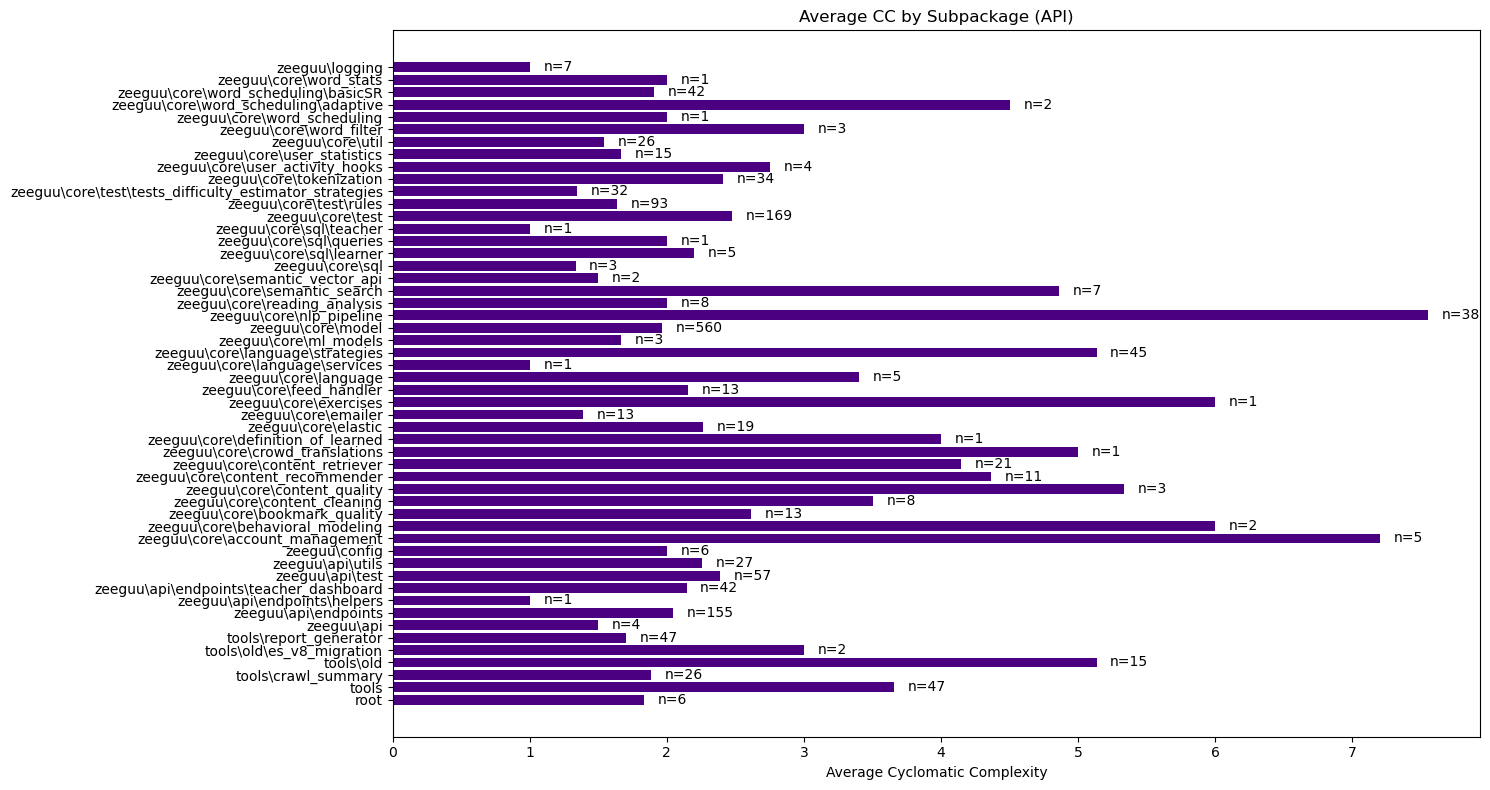

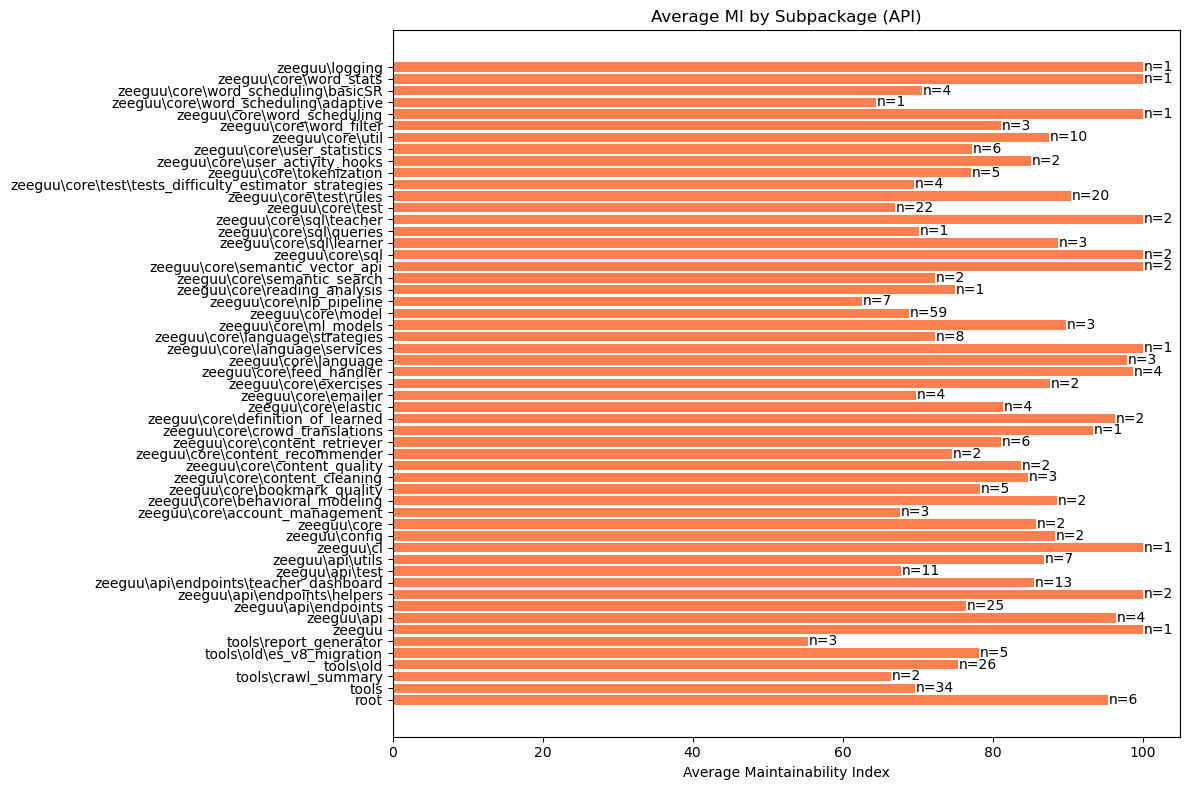

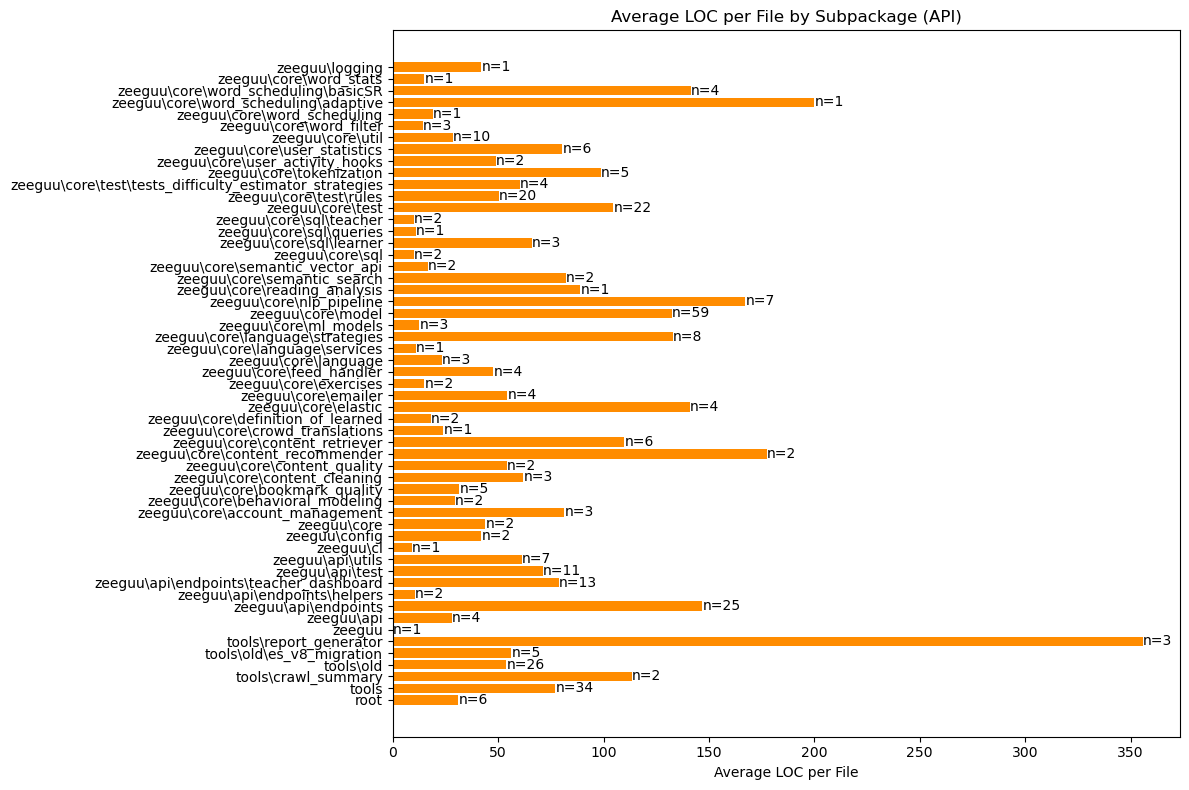

In [ ]:
import os
import sys
import json
import subprocess
from collections import defaultdict
import matplotlib.pyplot as plt

def aggregate_cc_by_subpackage(base_dir):
    cmd = [sys.executable, "-m", "radon", "cc", base_dir, "-j", "-s", "-a"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    pkg_data = defaultdict(list)
    for filepath, funcs in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = os.path.dirname(relpath)
        if pkg == "":
            pkg = "root"
        for func in funcs:
            pkg_data[pkg].append(func["complexity"])
    return pkg_data

def aggregate_mi_by_subpackage(base_dir):
    cmd = [sys.executable, "-m", "radon", "mi", base_dir, "-j"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    pkg_data = defaultdict(list)
    for filepath, mi_value in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = os.path.dirname(relpath)
        if pkg == "":
            pkg = "root"
        if isinstance(mi_value, dict):
            pkg_data[pkg].append(mi_value.get("mi", 0))
        else:
            pkg_data[pkg].append(mi_value)
    return pkg_data

def aggregate_raw_by_subpackage(base_dir):
    cmd = [sys.executable, "-m", "radon", "raw", base_dir, "-j", "-s"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    metrics = ["loc", "lloc", "sloc", "comments", "single_comments", "multi", "blank"]
    pkg_totals = defaultdict(lambda: {metric: 0 for metric in metrics})
    pkg_file_count = defaultdict(int)
    for filepath, stats in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = os.path.dirname(relpath)
        if pkg == "":
            pkg = "root"
        pkg_file_count[pkg] += 1
        for metric in metrics:
            pkg_totals[pkg][metric] += stats.get(metric, 0)
    return pkg_totals, pkg_file_count

if __name__ == "__main__":
    # Aggregate Cyclomatic Complexity by subpackage
    cc_subpkg = aggregate_cc_by_subpackage(API_DIR)
    subpkg_names = list(cc_subpkg.keys())
    avg_cc = [sum(cc_subpkg[p]) / len(cc_subpkg[p]) if cc_subpkg[p] else 0 for p in subpkg_names]

    plt.figure(figsize=(15, 6))
    bars = plt.barh(subpkg_names, avg_cc, color='indigo')
    plt.xlabel("Average Cyclomatic Complexity")
    plt.title("Average CC by Subpackage (API)")
    for bar, subpkg in zip(bars, subpkg_names):
        count = len(cc_subpkg[subpkg])
        plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f"n={count}", va='center', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(RADON_OUTPUT_DIR, 'average_cc_by_subpackage.png'))
    plt.show()

    # Aggregate Maintainability Index by subpackage
    mi_subpkg = aggregate_mi_by_subpackage(API_DIR)
    subpkg_names_mi = list(mi_subpkg.keys())
    avg_mi = [sum(mi_subpkg[p]) / len(mi_subpkg[p]) if mi_subpkg[p] else 0 for p in subpkg_names_mi]

    plt.figure(figsize=(12, 6))
    bars = plt.barh(subpkg_names_mi, avg_mi, color='coral')
    plt.xlabel("Average Maintainability Index")
    plt.title("Average MI by Subpackage (API)")
    for bar, subpkg in zip(bars, subpkg_names_mi):
        count = len(mi_subpkg[subpkg])
        plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f"n={count}", va='center', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(RADON_OUTPUT_DIR, 'average_mi_by_subpackage.png'))
    plt.show()

    # Aggregate Raw Metrics by subpackage
    raw_subpkg, subpkg_file_count = aggregate_raw_by_subpackage(API_DIR)
    subpkg_names_raw = list(raw_subpkg.keys())
    avg_loc = [raw_subpkg[p]['loc'] / subpkg_file_count[p] if subpkg_file_count[p] else 0 for p in subpkg_names_raw]

    plt.figure(figsize=(12, 6))
    bars = plt.barh(subpkg_names_raw, avg_loc, color='darkorange')
    plt.xlabel("Average LOC per File")
    plt.title("Average LOC per File by Subpackage (API)")
    for bar, subpkg in zip(bars, subpkg_names_raw):
        count = subpkg_file_count[subpkg]
        plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f"n={count}", va='center', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(RADON_OUTPUT_DIR, 'average_loc_by_subpackage.png'))
    plt.show()


## Visualize Package-Level Complexity

We create a bar chart that displays the average cyclomatic complexity per package. Only packages with at least 3 functions are included.

In [9]:
def visualize_package_complexity(df, title):
    package_complexity = df.groupby('package')['complexity'].agg(['mean', 'count'])
    package_complexity = package_complexity.sort_values('mean', ascending=False)
    package_complexity = package_complexity[package_complexity['count'] >= 3]
    
    plt.figure(figsize=(12, 8))
    bars = plt.bar(package_complexity.index, package_complexity['mean'])
    for i, bar in enumerate(bars):
        complexity = package_complexity['mean'].iloc[i]
        if complexity > 10:
            bar.set_color('red')
        elif complexity > 5:
            bar.set_color('orange')
        else:
            bar.set_color('green')
    plt.xlabel('Package')
    plt.ylabel('Average Cyclomatic Complexity')
    plt.title(f'{title} - Package Complexity')
    plt.xticks(rotation=90)
    plt.tight_layout()
    for i, bar in enumerate(bars):
        count = package_complexity['count'].iloc[i]
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'n={count}', ha='center', va='bottom', fontsize=8)
    return plt

if not api_df.empty:
    api_plot = visualize_package_complexity(api_df, 'API')
    api_plot.savefig(os.path.join(RADON_OUTPUT_DIR, 'api_package_complexity.png'))
    api_plot.show()
else:
    print("No API data available for visualization")

NameError: name 'api_df' is not defined

## Module Dependency Graph

We now construct a module dependency graph by extracting import statements from each Python file. This helps us see how modules depend on one another.

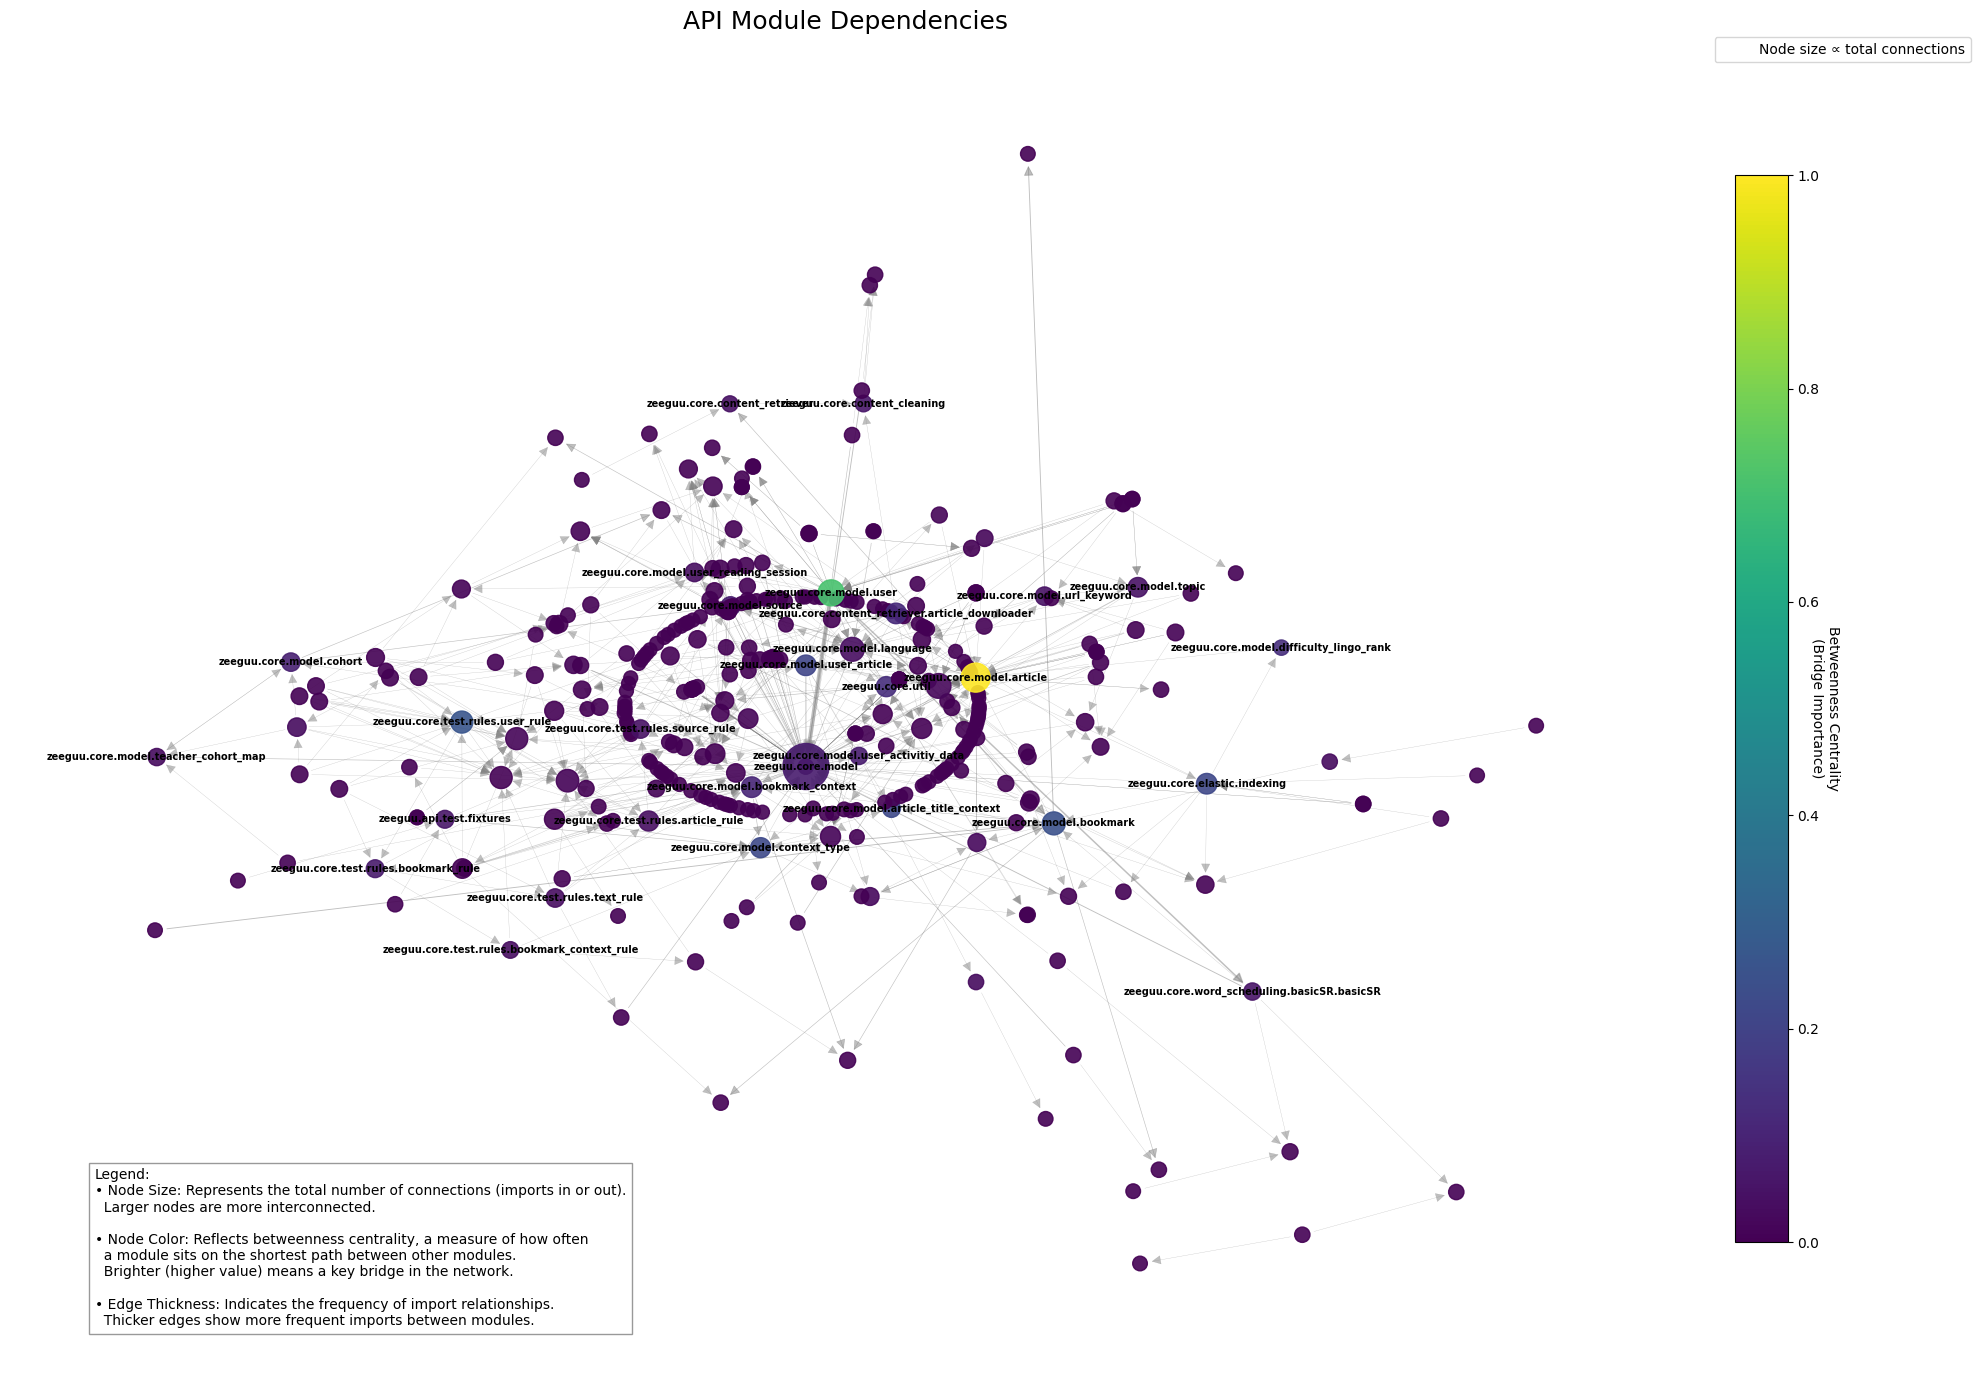

In [ ]:
import os
import re
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from pathlib import Path

# --- Utility Functions ---

def extract_imports(file_path):
    """
    Parse Python source code in file_path to find all direct import statements
    and return a list of imported dotted module names (e.g. 'zeeguu.core.models').
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
        # Matches both "from foo.bar import baz" and "import foo, bar"
        pattern = re.compile(r'^\s*(?:from\s+([\w\.]+)\s+import\s+|import\s+([\w\.\,\s]+))', re.MULTILINE)
        matches = pattern.findall(content)
        imports = []
        for from_import, direct_import in matches:
            if from_import:
                imports.append(from_import.strip())
            elif direct_import:
                for mod in direct_import.split(','):
                    imports.append(mod.strip())
        return imports
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return []

def get_python_files(directory):
    """Recursively collects all .py files under `directory`."""
    return list(Path(directory).rglob('*.py'))

def path_to_module_name(base_dir, file_path):
    """
    Convert a file path (relative to base_dir) into a dotted module name.
    For example, for file 'sub/folder/file.py', return 'sub.folder.file'.
    For an __init__.py file, use the folder as the module name.
    """
    rel_path = file_path.relative_to(base_dir)
    parts = list(rel_path.parts)
    if parts[-1] == '__init__.py':
        return ".".join(parts[:-1])
    else:
        parts[-1] = parts[-1][:-3]  # remove ".py"
        return ".".join(parts)

def discover_local_modules(base_dir):
    """
    Return a set of all dotted module names in this project.
    For a file path like 'zeeguu/core/models/something.py', produce 'zeeguu.core.models.something'.
    For an __init__.py, produce the package name.
    """
    local_modules = set()
    base = Path(base_dir).resolve()
    for file_path in base.rglob('*.py'):
        module_name = path_to_module_name(base, file_path)
        local_modules.add(module_name)
    return local_modules

def create_module_graph(base_dir):
    """
    Constructs a directed graph of internal module dependencies.
    Each node is a module's full dotted name (e.g. 'zeeguu.core.models.something').
    An edge from module A to module B is added if A imports B.
    Only edges for modules present in the project are added.
    """
    local_modules = discover_local_modules(base_dir)
    
    G = nx.DiGraph()
    for module in local_modules:
        G.add_node(module)
    
    base = Path(base_dir).resolve()
    for py_file in base.rglob('*.py'):
        mod_name = path_to_module_name(base, py_file)
        imports = extract_imports(py_file)
        for imp in imports:
            if imp in local_modules and imp != mod_name:
                if not G.has_edge(mod_name, imp):
                    G.add_edge(mod_name, imp, weight=1)
                else:
                    G[mod_name][imp]['weight'] += 1
    return G

# --- Updated Visualization Function with Explanatory Legend ---

def visualize_module_graph(G, title, output_dir):
    """
    Visualizes a module dependency graph with:
      - Node color: corresponds to betweenness centrality (how often a module acts as a bridge between others)
      - Node size: corresponds to total degree (sum of incoming and outgoing connections)
      - Edge thickness: indicates how many times one module imports another (the import frequency)
    
    Additionally, an explanatory legend is added so that a non-technical person can understand the meaning:
    
      * Node Size: A larger node means that the module is connected to more modules. In other words,
        it is imported by many other modules or itself imports many modules.
      
      * Node Color: The color indicates how important the module is as a bridge between other modules.
        Modules that are colored closer to the bright end of the color map (and have a higher number)
        serve as critical connection points in the codebase.
      
      * Edge Thickness: Thicker lines mean that the import relationship between two modules occurs more frequently.
    
    The resulting image is saved to the specified output_dir.
    """
    # Use Kamada-Kawai layout for better spacing
    pos = nx.kamada_kawai_layout(G)
    
    # Compute betweenness centrality for node color
    betweenness = nx.betweenness_centrality(G)
    max_bc = max(betweenness.values()) if betweenness else 1
    node_colors = [(betweenness[n] / max_bc) if max_bc != 0 else 0 for n in G.nodes()]
    
    # Compute total degree (in + out) for node size
    degree_dict = dict(G.degree())
    max_deg = max(degree_dict.values()) if degree_dict else 1
    node_sizes = [100 + 1000 * (degree_dict[n] / max_deg) for n in G.nodes()]
    
    # Use a colormap for node colors
    cmap = plt.cm.viridis
    vmin, vmax = 0, 1
    
    # Optionally, label only the top 30 nodes by betweenness to reduce clutter
    sorted_by_bc = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
    top_n = 30
    top_nodes = {node for node, _ in sorted_by_bc[:top_n]}
    labels = {n: n for n in top_nodes}
    
    plt.figure(figsize=(20, 14))
    
    # Draw edges with widths scaled by weight (edge thickness = import frequency)
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    edge_widths = [w / max_weight * 3 for w in edge_weights]
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color='gray', arrowsize=15)
    
    # Draw nodes
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        alpha=0.9
    )
    
    # Draw labels only for selected nodes
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=7, font_weight='bold')
    
    plt.title(f"{title} Module Dependencies", fontsize=18)
    plt.axis('off')
    
    # Create a colorbar for node color (betweenness centrality)
    ax = plt.gca()
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.03)
    cbar.set_label("Betweenness Centrality\n(Bridge Importance)", rotation=270, labelpad=15)
    
    # Create an explanatory legend text
    legend_text = (
        "Legend:\n"
        "• Node Size: Represents the total number of connections (imports in or out).\n"
        "  Larger nodes are more interconnected.\n\n"
        "• Node Color: Reflects betweenness centrality, a measure of how often\n"
        "  a module sits on the shortest path between other modules.\n"
        "  Brighter (higher value) means a key bridge in the network.\n\n"
        "• Edge Thickness: Indicates the frequency of import relationships.\n"
        "  Thicker edges show more frequent imports between modules."
    )
    
    # Add an explanatory text box to the figure (position can be adjusted)
    plt.gcf().text(0.05, 0.05, legend_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # Also add a small patch legend for node size
    size_patch = mpatches.Patch(color='white', label="Node size ∝ total connections")
    plt.legend(handles=[size_patch],
               loc="upper left",
               bbox_to_anchor=(1.02, 1),
               borderaxespad=0)
    
    plt.tight_layout()
    
    fname = os.path.join(output_dir, f"{title.lower().replace(' ', '_')}_module_dependencies.png")
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()


G = create_module_graph(API_DIR)

if len(G.nodes()) > 0:
    visualize_module_graph(G, "API", RADON_OUTPUT_DIR)
else:
    print("API graph has no nodes to visualize")


## 8. Module-Function Hierarchy View

In this section, we create a hierarchical view that shows each module and its top five most complex functions. This view can help identify key functions in architecturally significant modules.

pygraphviz not available; falling back to spring layout


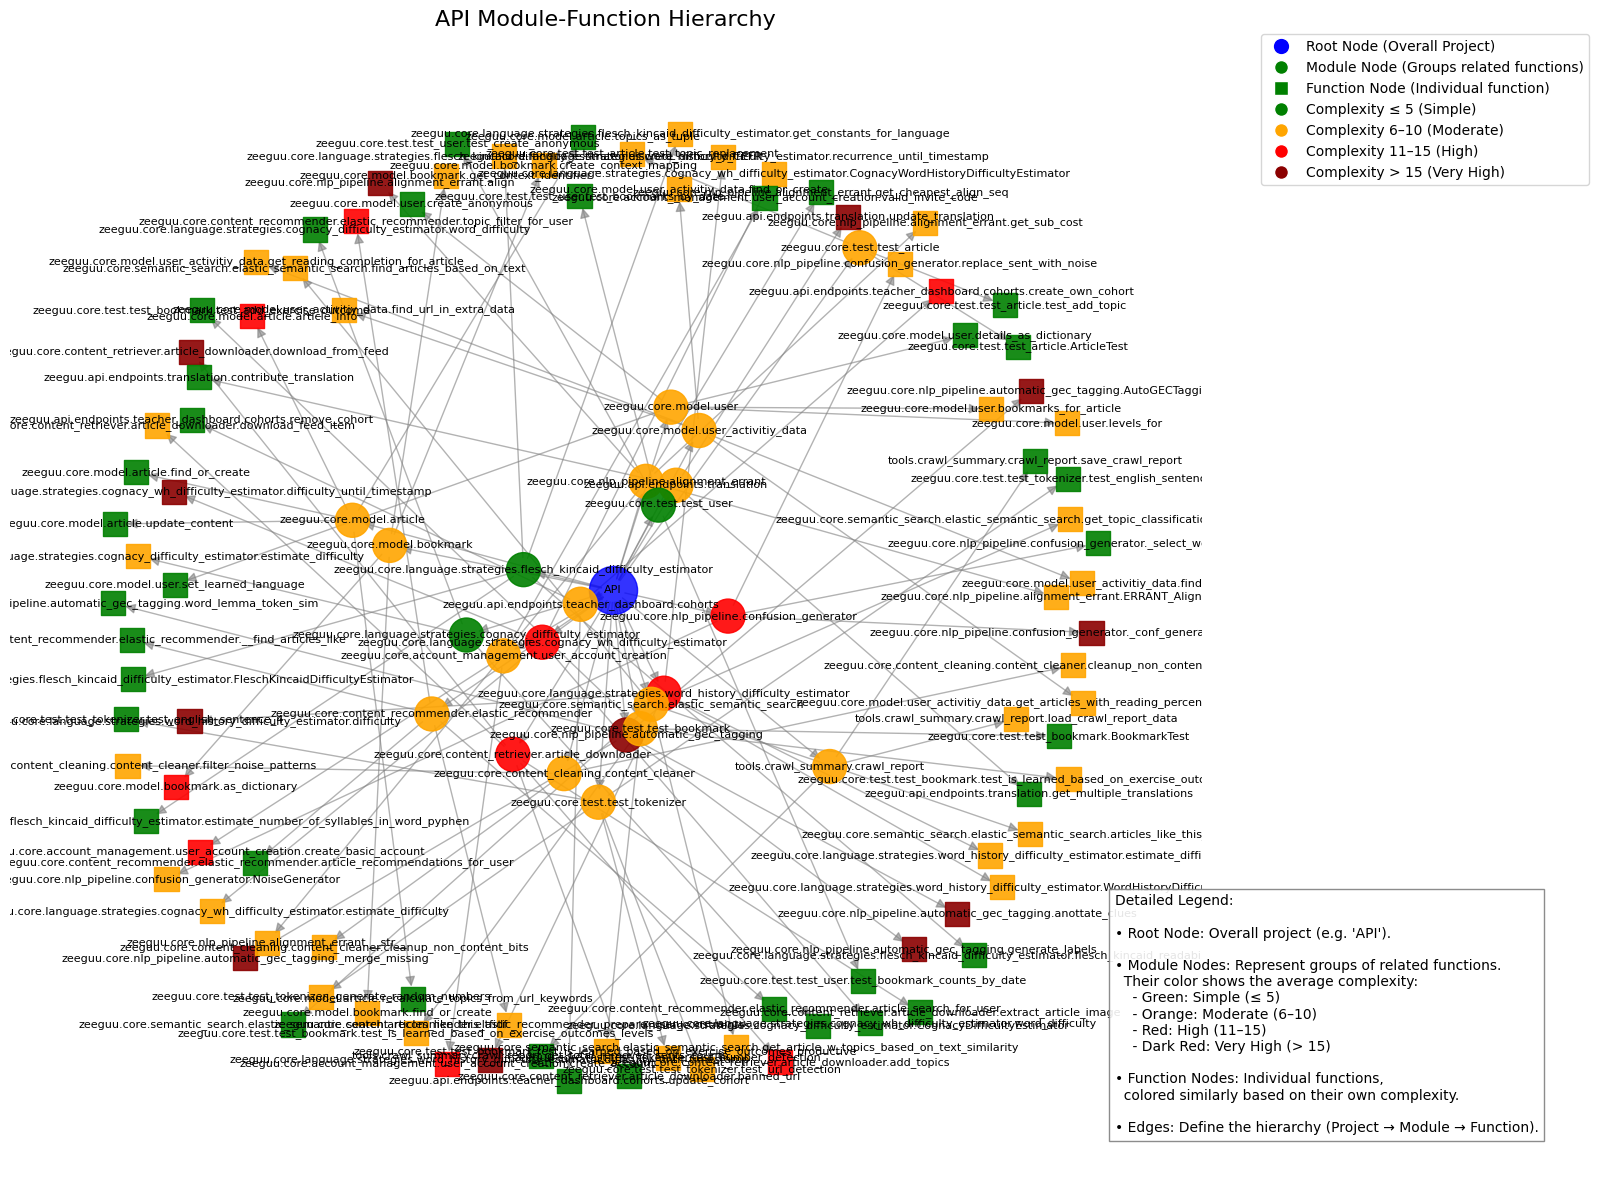

In [ ]:
import os
import json
import subprocess
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

# ------------------------------------------------------------------
# 1) Gather detailed complexity from Radon
# ------------------------------------------------------------------

def get_detailed_complexity(directory):
    """
    Uses 'radon cc' in JSON mode to gather cyclomatic complexity data
    for each Python file under 'directory', returning a dict keyed by
    full dotted module name.
    
    Example output structure:
      {
         "package.sub.module": [
             {"name": "func1", "complexity": 7, "rank": "B"},
             {"name": "func2", "complexity": 12, "rank": "C"},
             ...
         ],
         ...
      }
    """
    result = subprocess.run(
        [sys.executable, "-m", "radon", "cc", directory, "-j"],
        capture_output=True,
        text=True
    )
    try:
        data = json.loads(result.stdout)
    except json.JSONDecodeError:
        print(f"Error parsing JSON output from radon for {directory}")
        return {}
    
    module_data = {}
    base_path = Path(directory).resolve()

    for file_path_str, functions in data.items():
        file_path = Path(file_path_str).resolve()
        if not file_path.is_file():
            continue
        try:
            rel_path = file_path.relative_to(base_path)
        except ValueError:
            continue

        parts = list(rel_path.parts)
        if parts[-1] == '__init__.py':
            module = ".".join(parts[:-1])
        else:
            parts[-1] = parts[-1][:-3]  # remove '.py'
            module = ".".join(parts)

        if not module or module.startswith('_'):
            continue

        if module not in module_data:
            module_data[module] = []

        for func in functions:
            module_data[module].append({
                'name': func['name'],
                'complexity': func['complexity'],
                'rank': func['rank']
            })
    return module_data

# ------------------------------------------------------------------
# 2) Filter out less important data
# ------------------------------------------------------------------

def filter_detailed_data(module_data, min_functions=1, min_avg_complexity=0,
                         top_modules=None, min_func_complexity=0, top_functions=5):
    """
    Filters the module_data dict based on thresholds:
      - min_functions: Skip modules with fewer than this many functions.
      - min_avg_complexity: Skip modules whose average function complexity is below this.
      - top_modules: Keep only the top N modules (by descending average complexity).
      - min_func_complexity: Discard any function whose complexity is below this.
      - top_functions: For each module, keep only the top N functions by complexity.
    """
    filtered_data = {}
    for mod, funcs in module_data.items():
        filtered_funcs = [f for f in funcs if f['complexity'] >= min_func_complexity]
        if filtered_funcs:
            filtered_data[mod] = filtered_funcs

    # Remove modules with too few functions
    for mod in list(filtered_data.keys()):
        if len(filtered_data[mod]) < min_functions:
            del filtered_data[mod]

    # Remove modules with low average complexity
    for mod in list(filtered_data.keys()):
        avg_comp = sum(f['complexity'] for f in filtered_data[mod]) / len(filtered_data[mod])
        if avg_comp < min_avg_complexity:
            del filtered_data[mod]

    # If top_modules is set, keep only top N modules by average complexity
    if top_modules is not None and top_modules > 0:
        mods_sorted = sorted(
            filtered_data.items(),
            key=lambda kv: sum(f['complexity'] for f in kv[1]) / len(kv[1]),
            reverse=True
        )
        filtered_data = dict(mods_sorted[:top_modules])
    
    # For each module, keep only top N functions by complexity
    if top_functions is not None and top_functions > 0:
        for mod in filtered_data:
            sorted_funcs = sorted(filtered_data[mod], key=lambda x: x['complexity'], reverse=True)
            filtered_data[mod] = sorted_funcs[:top_functions]
            
    return filtered_data

# ------------------------------------------------------------------
# 3) Create a hierarchy visualization with an explanatory legend using shapes & color
# ------------------------------------------------------------------

def create_hierarchy_view(detailed_data, title, output_dir):
    """
    Creates a hierarchy graph with:
      - A root node representing the overall project.
      - Module nodes (circles) grouped under the root.
      - Function nodes (squares) under each module.
    
    Node color corresponds to complexity:
      • Green: Complexity ≤ 5 (Simple, straightforward code)
      • Orange: Complexity 6–10 (Moderately complex)
      • Red: Complexity 11–15 (High complexity)
      • Dark Red: Complexity > 15 (Very high complexity)
    
    Node shapes:
      • Root node: Large blue circle.
      • Module nodes: Circles.
      • Function nodes: Squares.
    
    A detailed legend with matching shapes and colors is added in the right margin.
    The layout is adjusted to provide space for the legend.
    """
    if not detailed_data:
        print(f"No detailed complexity data available for {title}")
        return

    def get_color(comp):
        if comp > 15:
            return 'darkred'
        elif comp > 10:
            return 'red'
        elif comp > 5:
            return 'orange'
        else:
            return 'green'

    G = nx.DiGraph()
    G.add_node(title, type='root')

    for module_name, func_list in detailed_data.items():
        avg_comp = sum(f['complexity'] for f in func_list) / len(func_list)
        G.add_node(module_name, type='module', complexity=avg_comp, color=get_color(avg_comp))
        G.add_edge(title, module_name)
        for func_info in func_list:
            fn_comp = func_info['complexity']
            node_name = f"{module_name}.{func_info['name']}"
            G.add_node(node_name, type='function', complexity=fn_comp, color=get_color(fn_comp))
            G.add_edge(module_name, node_name)

    # Try dot layout with extra spacing; fallback to spring layout if needed.
    try:
        pos = nx.nx_agraph.graphviz_layout(
            G,
            prog='dot',
            args='-Goverlap=false -Gmargin=1.5 -Granksep=1.5 -Gnodesep=1.0'
        )
    except Exception:
        print("pygraphviz not available; falling back to spring layout")
        pos = nx.spring_layout(G, k=0.3, iterations=50)

    fig = plt.figure(figsize=(16, 12))
    # Adjust the main plot to leave space for a legend on the right.
    plt.subplots_adjust(left=0.05, right=0.68, top=0.9, bottom=0.1)

    # Separate node types.
    root_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'root']
    module_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'module']
    function_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'function']

    # Draw nodes.
    nx.draw_networkx_nodes(G, pos, nodelist=root_nodes, node_size=1200,
                           node_color='blue', alpha=0.8)
    nx.draw_networkx_nodes(G, pos, nodelist=module_nodes, node_size=600,
                           node_color=[G.nodes[n]['color'] for n in module_nodes],
                           alpha=0.9)
    nx.draw_networkx_nodes(G, pos, nodelist=function_nodes, node_size=300,
                           node_color=[G.nodes[n]['color'] for n in function_nodes],
                           alpha=0.9, node_shape='s')

    # Draw edges and labels.
    nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=15, alpha=0.6, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.title(f"{title} Module-Function Hierarchy", fontsize=16)
    plt.axis('off')

    # Create a custom legend using Line2D objects.
    from matplotlib.lines import Line2D
    legend_elements = [
        # Root node: Blue circle.
        Line2D([0], [0], marker='o', color='w', label='Root Node (Overall Project)',
               markerfacecolor='blue', markersize=12),
        # Module node: Circle.
        Line2D([0], [0], marker='o', color='w', label='Module Node (Groups related functions)',
               markerfacecolor='green', markersize=10),
        # Function node: Square.
        Line2D([0], [0], marker='s', color='w', label='Function Node (Individual function)',
               markerfacecolor='green', markersize=10),
        # Complexity color keys.
        Line2D([0], [0], marker='o', color='w', label='Complexity ≤ 5 (Simple)',
               markerfacecolor='green', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Complexity 6–10 (Moderate)',
               markerfacecolor='orange', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Complexity 11–15 (High)',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Complexity > 15 (Very High)',
               markerfacecolor='darkred', markersize=10)
    ]
    # Place the legend outside the main plot area on the right.
    plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0)

    # Also add a text box with additional explanations to the far right.
    legend_text = (
        "Detailed Legend:\n\n"
        "• Root Node: Overall project (e.g. 'API').\n\n"
        "• Module Nodes: Represent groups of related functions.\n"
        "  Their color shows the average complexity:\n"
        "    - Green: Simple (≤ 5)\n"
        "    - Orange: Moderate (6–10)\n"
        "    - Red: High (11–15)\n"
        "    - Dark Red: Very High (> 15)\n\n"
        "• Function Nodes: Individual functions,\n"
        "  colored similarly based on their own complexity.\n\n"
        "• Edges: Define the hierarchy (Project → Module → Function)."
    )
    fig.text(0.70, 0.05, legend_text, fontsize=10, verticalalignment='bottom',
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray'))

    plt.tight_layout()
    out_name = os.path.join(output_dir, f"{title.lower()}_hierarchy.png")
    plt.savefig(out_name, dpi=300, bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    raw_data = get_detailed_complexity(API_DIR)

    # Filter data: adjust parameters to remove less important information.
    filtered = filter_detailed_data(
        raw_data,
        min_functions=3,
        min_avg_complexity=5,
        top_modules=30,
        min_func_complexity=4,
        top_functions=5
    )

    # Create and display the hierarchy view with the detailed legend.
    create_hierarchy_view(filtered, "API", RADON_OUTPUT_DIR)
